In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

import numpy as np

from scipy.constants import pi, e, hbar, h
from scipy import interpolate, ndimage, signal, optimize, linalg, stats

# Install via `pip install qtplot`
from qtplot.data import DatFile, Data2D

from functools import partial

## Load data

Could not find settings file Dev4_35.set
Could not find settings file Dev4_44.set


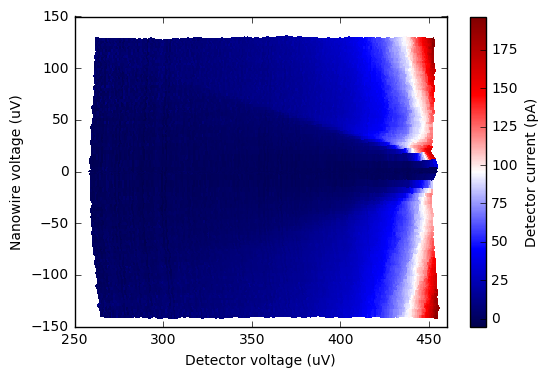

In [2]:
# IV trace of the detector junction, used for contructing an I_QP0 curve
name = 'Dev4_35.dat'
df = DatFile('data/' + name)

data_qp0 = df.get_data('V_meas_DET (V)',
                       'Triton magnet (B (T))',
                       'I_meas_DET (A)')

data_qp0.scale_axes(x_scale=-1)
data_qp0.scale_data(-1)

V_qp0_meas = data_qp0.x[0]
I_qp0_meas = data_qp0.z[0]



# Load PAT current dataset
name = 'Dev4_44.dat'
df = DatFile('data/' + name)

data_pat = df.get_data('V_meas_DET (V)', 
                   'V_meas_EMI (V)', 
                   'I_meas_DET (A)')

# Correct for offsets and scalings
# X_offset: offset of detector voltage
# Y_offset: offset of emmiter (NW) junction voltage
data_pat.offset_axes(x_offset=-4.5e-6 ,y_offset=-52e-6)
data_pat.sub_linecut(type='horizontal', position=0)
data_pat.crop(left=50)
data_pat.scale_axes(x_scale=-1)
data_pat.scale_data(-0.1) # Wrong Keithley gain for detector current
data_pat.autoflip()

x, y, z = data_pat.get_pcolor()
plt.pcolor(x / 1e-6, y / 1e-6, z / 1e-12, cmap='seismic', rasterized=True)
plt.xlim(250, 460)
plt.xlabel('Detector voltage (uV)')
plt.ylabel('Nanowire voltage (uV)')
plt.colorbar().set_label('Detector current (pA)')
plt.savefig('I_PAT vs NW vs DET.pdf', dpi=600)

## Define commonly used functions

In [6]:
def find_nearest(array, value):
    """ Helper function to return the index and closest value in an array """
    index = (np.abs(array - value)).argmin()

    return index, array[index]

def generate_qp0(V_qp0, two_delta, R_N, offset, smooth):
    """
    Generate an I_QP0 curve using a smoothened piecewise function
    
    two_delta: 2 x Superconducting gap
    R_N: Normal state resistance of detector junction
    offset: Voltage offset of the normal state resistance
    smooth: Gaussian smoothing kernel size
    """
    I_qp0 = np.piecewise(V_qp0,
                         [V_qp0 < two_delta, V_qp0 >= two_delta],
                         [0, lambda x: (1 / R_N) * (x - offset)])

    # Smooth the piecewise function
    I_qp0 = ndimage.filters.gaussian_filter1d(I_qp0, smooth)

    return I_qp0

def single_freq_pat(V_qp0, I_qp0, I_c, f, V, Z):
    """
    Analytical formula for the PAT current due to monochromatic radiation.
    
    I_c: Emitter junction critical current (A)
    f: Radiation frequency (Hz)
    V: Voltage array to calculate PAT current on (V)
    Z: Transimpedance (Ohm)
    """
    I_qp0_f = interpolate.interp1d(V_qp0, I_qp0)
    
    V_shift = (h * f) / e
    I = (1/4) * ((e * Z * I_c) / (h * f))**2 * I_qp0_f(V + V_shift)
    
    return I

def convolute(f, I_qp0, S_v):
    """
    Convolute a voltage noise PSD with an I_QP0 curve.
    The voltage spacing of I_qp0 is related to that of omegas and S_v
    by dV = (h * df) / e
    
    f: Frequency array (Hz)
    I_qp0: ideal detector I(V) generated by generate_qp0(...)(A)
    S_v: voltage noise spectral density (V^2/Hz)
    
    returns: PAT current array (A)
    """
    df = f[1] - f[0]
    
    # Construct a lower triangular Toeplitz matrix for discrete convolution
    A = linalg.tril(linalg.toeplitz(I_qp0))
    b = (e / (h * f[:0:-1]))**2 * S_v[:0:-1] * df

    return A.dot(b)

def deconvolute(f, I_qp0, I_pat, tikhonov):
    """
    Deconvolute the measured PAT current using I_qp0 to retrieve S_v.
    Tikhonov regularization is used to reduce the dependence of the output
    on noise in the measured PAT current.
    
    f: Frequency array (Hz)
    I_qp0: ideal detector I(V) generated by generate_qp0(...)(A)
    I_pat: measured detector response (A)
    tikhonov: Tikhonov regularization factor
    """
    A = linalg.tril(linalg.toeplitz(I_qp0))
    A = np.concatenate((A, tikhonov * np.identity(A.shape[0])))

    b = np.concatenate((I_pat, np.zeros(len(I_pat))))

    x, residual = optimize.nnls(A, b)

    df = f[1] - f[0]
    S_v = x[::-1] / (df * (e / (h * f))**2)
    
    return x, residual, S_v

def integrate_peak_area(f, S_v, expected=None, radius=None):
    """ 
    Find the closest zero or local minima to the maximum and integrate 
    
    f: Frequency array (Hz)
    S_v: Voltage noise density array (V^2/Hz)
    expected: Expected center frequency (Hz)
    radius: Distance around expected frequency to evaluate (Hz)
    """
    
    if expected is None:
        max_ind = np.argmax(S_v[:-1])
    else:
        S_v_sub = S_v.copy()
        
        # Only look for a maximum in the 'expected' frequency range
        mask = (f < expected - radius) | (f > expected + radius)
        S_v_sub[mask] = 0
        
        max_ind = np.argmax(S_v_sub)
    
    # Find local minima and zero's and sort based on index
    min_ind = signal.argrelmin(S_v)[0]
    zero_ind = np.where(S_v == 0)[0]
    indices = np.sort(np.concatenate((min_ind, zero_ind)))

    # Pick the local minima left and right of the found maximum
    left_ind = indices[indices < max_ind]
    right_ind = indices[indices > max_ind]
    
    left = 0 if len(left_ind) == 0 else left_ind[-1]
    right = 0 if len(right_ind) == 0 else right_ind[0]
    
    # Integrate between the two chosen local minima
    area = np.trapz(S_v[left:right+1], dx=f[1]-f[0])
    
    return area, left, max_ind, right

def l_curve(f, I_qp0, I_pat, steps=50):
    """
    Use the L-curve method to find the optimal Tikhonov regularization factor.
    
    Method adapted from:
    Hansen, P. C. (1999). The L-curve and its use in the numerical treatment of 
    inverse problems.
    
    f: Frequency array (Hz)
    I_qp0: ideal detector I(V) generated by generate_qp0(...)(A)
    I_pat: measured detector response (A)
    steps: number of datapoints evaluated on the L-curve
    """
    # range to evaluate L-curve on
    start = -10 
    stop = -7
    factors = np.logspace(start, stop, steps)
    residuals = np.zeros(len(factors))
    norms = np.zeros(len(factors))

    for i, factor in enumerate(factors):
        x, residual, _ = deconvolute(f, I_qp0, I_pat, factor)

        residuals[i] = residual
        norms[i] = np.sqrt(x.dot(x))

    x, y = np.log(residuals), np.log(norms)
    dx, dy = np.gradient(x), np.gradient(y)
    ddx, ddy = np.gradient(dx), np.gradient(dy)
    
    # Calculate the curvature of the L-curve
    k = (dx * ddy - dy * ddx) / (dx**2 + dy**2)**(3.0 / 2.0)

    def asym_gaussian(x, center, fwhm, w2, w3, power):
        fwhm, w2, w3, power = map(np.abs, [fwhm, w2, w3, power])
        
        return power * 1/(1+np.exp(-(x-center+fwhm/2)/w2)) * (1-1/(1+np.exp(-(x-center-fwhm/2)/w3)))

    # An asymmetric Gaussian is fitted to the curvature data in order to find the peak,
    # as it can be noisy due to the second derivatives.
    guess = [-8, 0.1, 0.1, 0.1, 8]
    popt, pcov = optimize.curve_fit(asym_gaussian, np.log10(factors), k, p0=guess)
    
    ret = {
        'factor_curvature': popt[0],
        #'best_factor': best_factor,
        #'index': index,
        'factors': factors,
        'residuals': residuals,
        'norms': norms,
    }
    
    return ret

def deconvolute_linetrace(V_pat, I_pat, 
                          V_qp0, I_qp0, 
                          V_min, V_c,
                          tikhonov=0, Z_fit=False, make_l_curve=False):
    
    """
    V_pat, I_pat: measured data array
    V_qp0, I_qp0: generated detector trace
    V_min: minimum voltage to evaluate I_pat
    V_c: maximum voltage to evaluate I_pat
    tikhonov: Tikhonov parameter, see functions l_curve and deconvolute
    Z_fit: enables fit of transimpedance (may take some time!)
    make_l_curve: enables adaptive Tikhonov parameter. If false, Tikhonov parameter is set by tikhonov.
    """
    
    # Indices for the region to deconvolute
    V_min_idx = int(find_nearest(V_qp0, V_min)[0])
    V_c_idx = int(find_nearest(V_qp0, V_c)[0])
    size = V_c_idx - V_min_idx
    
    # Frequencies and step size for the region
    df = (e * (V_qp0[1] - V_qp0[0])) / h
    f = np.arange(0, size) * df
    
    # Linearly interpolate I_pat onto regularly spaced voltages V_qp0
    I_pat_interp = np.interp(V_qp0, V_pat, I_pat, 
                             left=np.nan, right=np.nan)
    
    # If the option is set, use the L-curve method to find the optimal regularization parameter value
    l_curve_ret = None
    if make_l_curve:
        l_curve_ret = l_curve(f, I_qp0[V_c_idx:V_c_idx+size], I_pat_interp[V_min_idx:V_c_idx], steps=100)
        tikhonov = l_curve_ret['factor_curvature']
    
    # Deconvolute the linetrace
    _, _, S_v = deconvolute(f, I_qp0[V_c_idx:V_c_idx+size],
                      I_pat_interp[V_min_idx:V_c_idx], 10**tikhonov)
    
    # Convolute S_v to inspect the working of the deconvolution
    I_pat_conv = convolute(f, I_qp0[V_c_idx:V_c_idx+size-1], S_v)
    
    I_pat_subset = None
    I_fit = None
    Z = 0
    
    # Fit a single-frequency PAT current trace
    if Z_fit:
        # We take a subset around the peak of the deconvoluted spectrum to remove the contributions of white noise
        S_v_subset = S_v.copy()
        f_center = f[np.nanargmax(S_v_subset[:-1])]

        # Only retain the central peak in S_v
        S_v_subset[f < f_center - 3e9] = 0
        S_v_subset[f > f_center + 3e9] = 0
        
        # Convolute the subset of S_v to get a PAT trace without influence of white noise
        I_pat_subset = convolute(f, I_qp0[V_c_idx:V_c_idx+size-1], S_v_subset)
        
        # Create the single-frequency PAT fit functions. An Ic of the nanowire junction of 9.35 nA from another fitting procedure is used
        fit_func = partial(single_freq_pat, V_qp0, I_qp0, 9.34e-9, f_center)

        try:
            # Fit a single-frequency PAT curve to the back-calculated trace
            guess = [1e3]
            popt, pcov = optimize.curve_fit(fit_func,
                                            V_qp0[V_min_idx:V_c_idx-1],
                                            I_pat_subset,
                                            guess)

            Z = popt[0]
            
            # Return the fit results for inspection
            I_fit = fit_func(V_qp0[V_min_idx:V_c_idx-1], *popt)
        except RuntimeError as ex:
            print('Fit failed')
    
    return f, S_v, V_qp0[V_min_idx:V_c_idx-1], I_pat_conv, I_pat_subset, I_fit, Z, l_curve_ret

## Single linetrace
The contructed $I_{QP0}$ trace is compared to the measured one. Also, the working of the deconvolution and regularization is evaluated for a single $I_{PAT}$ trace.

-8.1464837729


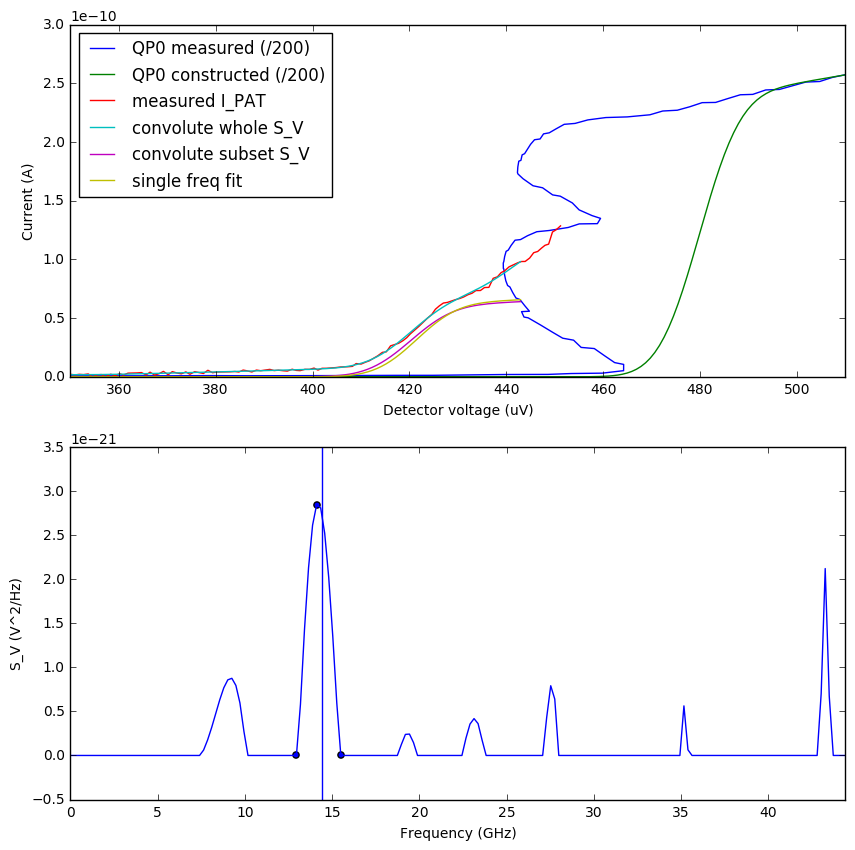

In [7]:
idx = 64

V_emi = np.average(data_pat.y[idx])
f_expect = abs(2 * (V_emi * e) / h)

V_pat, I_pat = data_pat.x[idx], data_pat.z[idx]
dV = float(np.average(np.diff(V_pat))) / 1

V_interp = np.arange(0, 800e-6, dV)

I_qp0 = generate_qp0(V_interp, 
                     two_delta=479.5e-6, 
                     R_N=7097, 
                     offset=145e-6, 
                     smooth=7)

f, S_v, V, I_conv, I_subset, I_fit, Z, l_curve_ret = deconvolute_linetrace(V_pat, I_pat,
                               V_interp, I_qp0,
                               260e-6, 445e-6, 10**-7.7, Z_fit=True, make_l_curve=True)

print(l_curve_ret['factor_curvature'])

area, left, center, right = integrate_peak_area(f, S_v)

plt.figure(figsize=(10,10))
plt.subplot(2, 1, 1)

scale = 2e2
plt.plot(V_qp0_meas / 1e-6, I_qp0_meas / scale, label='QP0 measured (/200)')
plt.plot(V_interp / 1e-6, I_qp0 / scale, label='QP0 constructed (/200)')

plt.plot(V_pat / 1e-6, I_pat, label='measured I_PAT')
plt.plot(V / 1e-6, I_conv, label='convolute whole S_V')
plt.plot(V / 1e-6, I_subset, label='convolute subset S_V')
plt.plot(V / 1e-6, I_fit, label='single freq fit')
plt.xlim(350, 510)
plt.ylim(0, 0.3e-9)
plt.xlabel('Detector voltage (uV)')
plt.ylabel('Current (A)')
plt.legend(loc='upper left')

plt.subplot(2, 1, 2)
plt.plot(f/1e9, S_v)
plt.scatter(f[left]/1e9, S_v[left])
plt.scatter(f[center]/1e9, S_v[center])
plt.scatter(f[right]/1e9, S_v[right])
plt.axvline(f_expect / 1e9)
plt.xlim(0, f[-1]/1e9)
plt.xlabel('Frequency (GHz)')
plt.ylabel('S_V (V^2/Hz)')

# All linetraces, individual L-curve and factor

(30, 193) (30, 193) (30, 193)


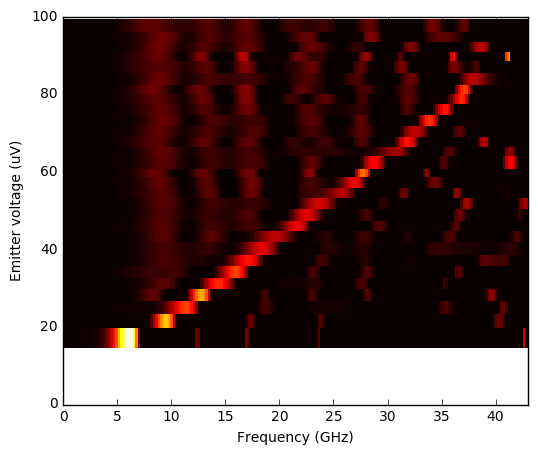

In [8]:
#array indeces to evaluate the measured data on the vertical axis
start, stop = 60, 90
traces = stop - start

center_freqs = np.zeros(traces)
areas = np.zeros(traces)

V_emi = np.zeros(traces)
S_v_2d = None
Z_fits = np.zeros(traces)

# Iterate over all the linetraces of interest
for i in range(0, traces):
    idx = start + i

    V_emi[i] = np.average(data_pat.y[idx])
    f_expect = abs(2 * (V_emi[i] * e) / h)

    V_pat, I_pat = data_pat.x[idx], data_pat.z[idx]

    # Deconvolute the linetrace
    f, S_v, _, _, _, _, Z, l_curve_ret = deconvolute_linetrace(V_pat, I_pat,
                               V_interp, I_qp0,
                               265e-6, 450e-6, 0, Z_fit=True, make_l_curve=True)

    #print('Trace {}: Tikhonov factor: {}'.format(idx, l_curve_ret['factor_curvature']))

    # Store the transimpedance fit values and integrated S_V peak values
    Z_fits[i] = Z

    mask = (f < 40e9)
    areas[i], left, center, right = integrate_peak_area(f[mask], S_v[mask], f_expect, 3e9)
    center_freqs[i] = f[center]

    if S_v_2d is None:
        S_v_2d = np.zeros((traces, len(S_v)))

    S_v_2d[i] = S_v

V_emis = np.tile(V_emi[:,np.newaxis], len(S_v))
freqs = np.tile(f, (traces, 1))

print(V_emis.shape, freqs.shape, S_v_2d.shape)

plt.figure(figsize=(6,5))
plt.pcolor(freqs / 1e9, V_emis / 1e-6, S_v_2d, cmap='hot', rasterized=True)
plt.xlim(0, 43)
plt.ylim(0, 100)
plt.xlabel('Frequency (GHz)')
plt.ylabel('Emitter voltage (uV)')
plt.savefig('NW vs Freq.pdf', dpi=600)

# $S_V$ peaks

Slope: 4.75e+14 pm 4.20e+12


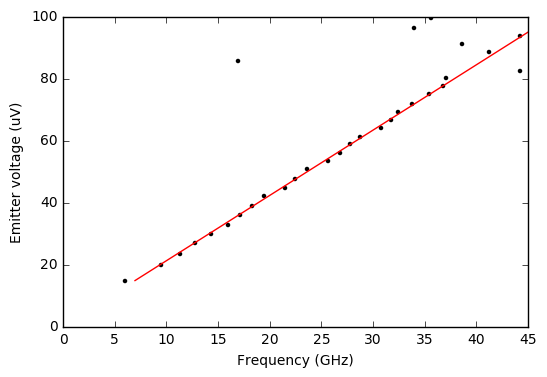

In [10]:
# find the maxima of the previous plot
# Mask outliers for which the peak clearly doesn't correspond to
# that caused by Josephson radiation
ind = np.nanargmax(S_v_2d[:,:-1], axis=1)
x = freqs[0,ind]
y = V_emis[:,0]


mask = (y > 10e-6) & (y < 80e-6) & (x < 40e9)

plt.scatter(x/1e9, y / 1e-6, color='black', s=5)

plt.xlim(0, 45)
plt.ylim(0, 100)
plt.xlabel('Frequency (GHz)')
plt.ylabel('Emitter voltage (uV)')

#get the voltage dependence of the Josephson radiation frequency
slope, intercept, rval, pval, stderr = stats.linregress(y[mask], x[mask])
plt.plot((y*slope+intercept)/1e9, y/1e-6, color='red')

print('Slope: {:.2e} pm {:.2e}'.format(slope, stderr))
plt.savefig('NW voltage vs freq.pdf')
np.savetxt('NW voltage vs freq.txt', np.vstack((x, y)).T)

# Transimpedance with L-curve for every trace

c:\python34\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


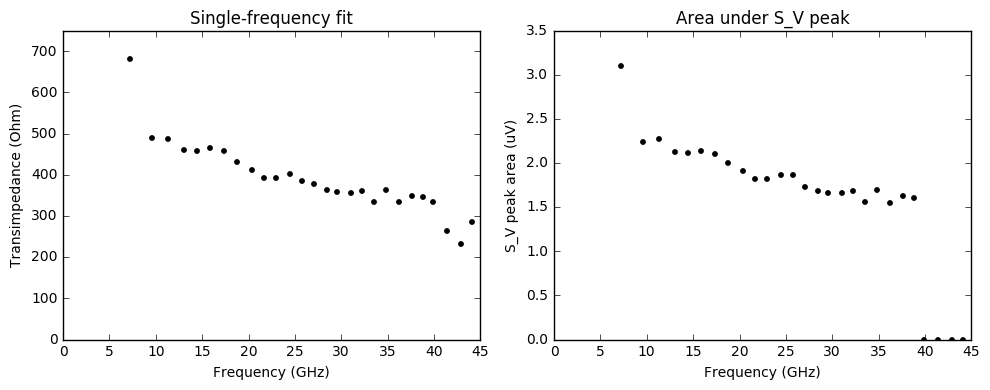

In [11]:
f_from_V = (2 * V_emi * e) / h

plt.figure(figsize=(10,4))

plt.subplot(1, 2, 1)
plt.scatter(f_from_V / 1e9, Z_fits, color='black', s=10)
plt.subplot(1, 2, 2)
plt.scatter(f_from_V / 1e9, np.sqrt(areas) / 1e-6, color='black', s=10)

plt.subplot(1, 2, 1)
plt.title('Single-frequency fit')
plt.xlim(0, 45)
plt.ylim(0, 750)
plt.xlabel('Frequency (GHz)')
plt.ylabel('Transimpedance (Ohm)')

plt.subplot(1, 2, 2)
plt.title('Area under S_V peak')
plt.xlim(0, 45)
plt.ylim(0, 3.5)
plt.xlabel('Frequency (GHz)')
plt.legend()
plt.ylabel('S_V peak area (uV)')

plt.tight_layout()
plt.savefig('transimpedance and peak area.pdf')
np.savetxt('transimpedance and peak area.txt', np.vstack((f_from_V, Z_fits, areas)).T)

## Quasiparticle noise and JJ spectrum fit using Fano factor

In [95]:
def model(V_qp0, I_qp0,
          V_min, V_c,
          V_emi, I_c, R_qp, R, f_0, fano=1):
    """
    Generate a PAT current by convolution of a current PSD consisting
    of a white noise quasiparticle background and JJ peak at the expected
    frequency.
    
    V_emi: Emitter junction voltage (V)
    I_c: Emitter critical current (A)
    R_qp: Normal state resistance (Ohm)
    R / f_0: RC fit parameters
    fano: Fano factor
    """
    V_min_idx = int(find_nearest(V_qp0, V_min)[0])
    V_c_idx = int(find_nearest(V_qp0, V_c)[0])
    size = V_c_idx - V_min_idx
    
    # Define the frequencies
    df = (e * (V_qp0[1] - V_qp0[0])) / h
    f = np.arange(0, size) * df

    # Flat quasiparticle noise
    S_I = np.zeros(size)
    S_I += (e * V_emi) / R_qp * fano * 2 * pi
    
    # Place a peak value at the expected JJ frequency, as used in the single-frequency PAT model
    f_expect = abs(2 * (V_emi * e) / h)
    idx = int(find_nearest(f, f_expect)[0])
    S_I[idx] = I_c**2 / (4 * df)
    
    # Transimpedance from RC fit
    Z_squared = R**2 / (1 + (f / (f_0))**2)
    S_V = S_I * Z_squared
    
    # Convolute S_V with I_QP0
    V_conv = V_qp0[V_min_idx:V_c_idx-1]
    I_conv = convolute(f, I_qp0[V_c_idx:V_c_idx+size-1], S_V)
    
    return V_conv, I_conv

def all_linetraces_fano_error(fano):
    """
    Assuming a global Fano factor, sum the squared errors of a fit using the
    model above to every linetrace.
    """
    errors = None
    
    for idx in range(75, 76):
        V_pat, I_pat = data_pat.x[idx,:], data_pat.z[idx,:]

        V_emi = np.average(data_pat.y[idx])

        dV = float(np.average(np.diff(V_pat))) / 1
        dV = 0.95e-7
        V_interp = np.arange(0, 800e-6, dV)

        I_qp0 = generate_qp0(V_interp, 
                             two_delta=479.5e-6, 
                             R_N=7097, 
                             offset=145e-6, 
                             smooth=7)

        #V_conv, I_conv = model(V_interp, I_qp0, 265e-6, 445e-6, 
        #                       V_emi=V_emi, I_c=9.34e-9, R_qp=14032, R=492, f_0=33.1e9, fano=fano)
        
        V_conv, I_conv = model(V_interp, I_qp0, 265e-6, 445e-6, 
                               V_emi=V_emi, I_c=9.34e-9, R_qp=14032, R=492, f_0=33.1e9, fano=fano)

        I_pat_int = interpolate.interp1d(V_pat, I_pat)
        
        if errors is None:
            errors = np.zeros(len(V_conv))

        errors += (I_pat_int(V_conv) - I_conv)**2
    
    return np.sqrt(errors)

In [96]:
# Use a least-squares procedure to search for the best Fano factor to fit the model to the data
optimize.leastsq(all_linetraces_fano_error, x0=[0.25])

(array([ 0.3077111]), 2)

0 5 59
1 10 59
2 20 61
3 25 62
4 30 64
5 40 67
6 50 71
7 60 75
8 70 78
9 80 82
10 90 86


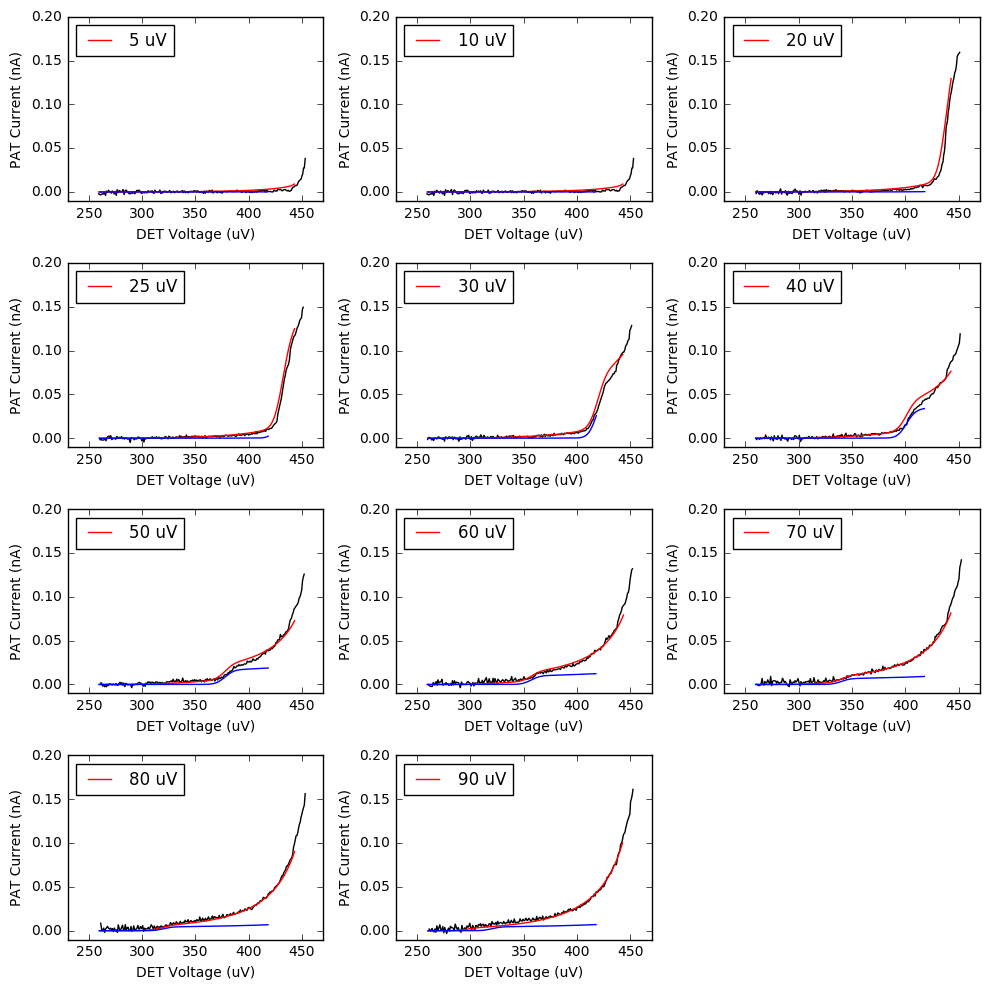

In [92]:
#R_qp=14032
#voltages = [15.8, 24.0, 33.0, 42, 50.8, 120]
#voltages = [24.0, 33.0, 42, 50.8, 64.4, 120]
voltages = [5,10,20, 25, 30, 40, 50, 60, 70, 80, 90]
#voltages = [16,24,33,51,64, 120,120,120,120,120]

plt.figure(figsize=(10,10))
units_x = 1e6
units_y = 1e9
scale = 2e2

for i, v in enumerate(voltages):
    V_pat, I_pat, idx = data_pat.get_row_at(v * 1e-6)
    print(i,v,idx)

    V_emi = np.average(data_pat.y[idx])

    dV = float(np.average(np.diff(V_pat))) / 1
    V_interp = np.arange(0, 800e-6, dV)

    I_qp0 = generate_qp0(V_interp, 
                         two_delta=479.5e-6, 
                         R_N=7097, 
                         offset=145e-6, 
                         smooth=7)

    V_conv, I_conv = model(V_interp, I_qp0, 260e-6, 445e-6, 
                           V_emi=V_emi, I_c=9.34e-9, R_qp=14000, R=493, f_0=34e9, fano=0.26)
    
    V_conv2, I_conv2 = model(V_interp, I_qp0, 260e-6, 420e-6, 
                           V_emi=V_emi, I_c=9.34e-9, R_qp=1400000, R=493, f_0=34e9)

    plt.subplot(4, 3, i + 1)
    plt.xlim(230, 470)
    plt.ylim(-0.01, 0.2)
    plt.ylabel('PAT Current (nA)')
    plt.xlabel('DET Voltage (uV)')

    plt.plot(V_pat*units_x, I_pat*units_y, color='black')
    plt.plot(V_conv*units_x, I_conv*units_y, label='{} uV'.format(v), color='red')
    plt.legend(loc='upper left')
    plt.plot(V_conv2*units_x, I_conv2*units_y, color='blue')

plt.tight_layout()
plt.savefig('PAT_QP_Fig4.pdf')

## Quantum efficiency
$QE=\frac{2I_{PAT}}{\Delta I_{ICPT}}$

$\eta=\frac{2I_{PAT}}{I_{ICPT}}$

For every trace:
- Find V_DET for highest I_PAT slope
- Find I_ICPT and delta I_ICPT
- Calculate values

$\Delta\eta=\sqrt{(\frac{2}{I_{ICPT}})^2(\Delta I_{PAT})^2+(-\frac{2I_{PAT}}{I_{ICPT}^2})^2(\Delta I_{ICPT})^2}$

Could not find settings file Dev4_44.set


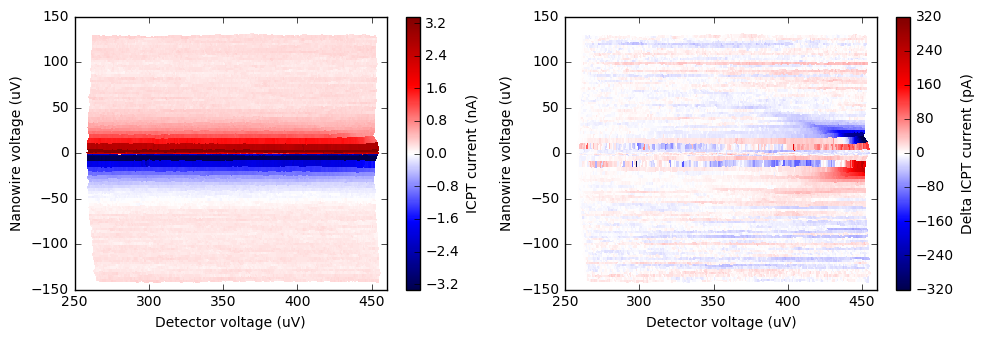

In [69]:
# Load PAT current dataset
name = 'Dev4_44.dat'
df = DatFile('data/' + name)

data_icpt = df.get_data('V_meas_DET (V)', 
                        'V_meas_EMI (V)', 
                        'I_meas_EMI (V)')

# Correct for voltage offsets and scalings
data_icpt.offset_axes(x_offset=-4.5e-6 ,y_offset=-52e-6)
data_icpt.crop(left=50)
data_icpt.scale_axes(x_scale=-1)
data_icpt.autoflip()
data_icpt.scale_data(-1.0)

I_nw = data_icpt.z.copy()
data_icpt.z -= data_icpt.y / 14.2e3
I_icpt_mat = data_icpt.z.copy()

# Plot the absolute ICPT current
plt.figure(figsize=(10, 3.5))
plt.subplot(1, 2, 1)
x, y, z = data_icpt.get_pcolor()
plt.pcolor(x / 1e-6, y / 1e-6, z / 1e-9, cmap='seismic', rasterized=True)
plt.xlim(250, 460)
plt.xlabel('Detector voltage (uV)')
plt.ylabel('Nanowire voltage (uV)')
plt.colorbar().set_label('ICPT current (nA)')

# Save the absolute ICPT current and change in ICPT current for later
data_icpt.z = I_nw
data_icpt.sub_linecut(type='vertical', position=200e-6)
dI_icpt_mat = data_icpt.z

# Plot the change in ICPT current
plt.subplot(1, 2, 2)
x, y, z = data_icpt.get_pcolor()
plt.pcolor(x / 1e-6, y / 1e-6, z / 1e-12, vmin=-320, vmax=320, cmap='seismic', rasterized=True)
plt.xlim(250, 460)
plt.xlabel('Detector voltage (uV)')
plt.ylabel('Nanowire voltage (uV)')
plt.colorbar().set_label('Delta ICPT current (pA)')
plt.tight_layout()
#plt.savefig('I_PAT vs NW vs DET.pdf', dpi=600)

1.68634581635e-12
2.25359263059e-11


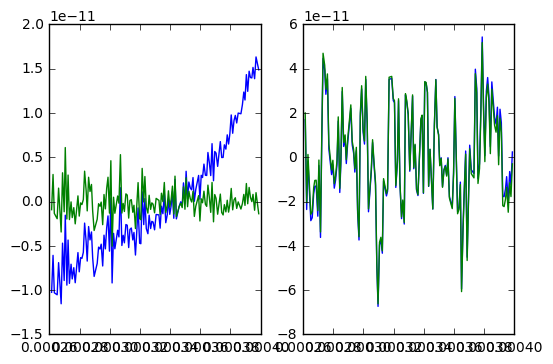

In [71]:
def estimate_noise(x, y, degree):
    p = np.poly1d(np.polyfit(x, y, degree))
                             
    plt.plot(x, y - np.average(y))
    
    removed = y - p(x)
    
    plt.plot(x, removed)
    
    print(np.std(removed))

idx = 90
V_det, I_pat = data_pat.x[idx], data_pat.z[idx]

part = (V_det < 400e-6)

plt.subplot(1, 2, 1)
estimate_noise(V_det[part], I_pat[part], 3)

plt.subplot(1, 2, 2)
I_icpt = I_icpt_mat[idx]
estimate_noise(V_det[part], I_icpt[part], 3)

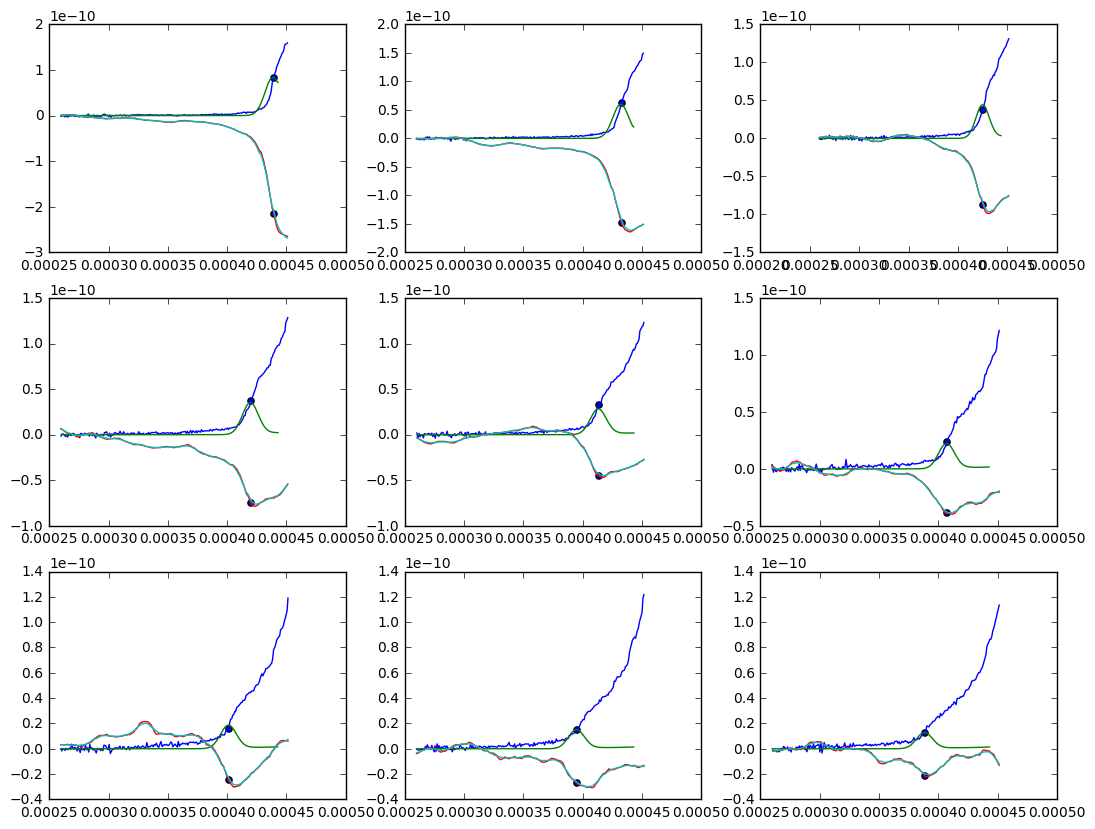

In [74]:
plt.figure(figsize=(13, 10))

I_pat_err = 1.2e-12
I_icpt_err = 22.5e-12

start, stop = 61, 70
indices = list(range(start, stop))
n = len(indices)
V_emis = np.zeros(n)
effs, effs_err = np.zeros(n), np.zeros(n)
etas, etas_err = np.zeros(n), np.zeros(n)

for idx in indices:
    i = idx - start
    
    V_det, I_pat = data_pat.x[idx], data_pat.z[idx]

    V_emi = np.average(data_pat.y[idx])
    V_emis[i] = V_emi

    dV = float(np.average(np.diff(V_det))) / 1
    V_interp = np.arange(0, 800e-6, dV)

    I_qp0 = generate_qp0(V_interp, 
                         two_delta=479.5e-6, 
                         R_N=7097, 
                         offset=145e-6, 
                         smooth=7)

    V_conv, I_conv = model(V_interp, I_qp0, 260e-6, 445e-6, 
                           V_emi=V_emi, I_c=9.34e-9, R_qp=14000, R=493, f_0=34e9, fano=0.277)
    
    V_conv2, I_conv2 = model(V_interp, I_qp0, 260e-6, 445e-6, 
                           V_emi=V_emi, I_c=9.34e-9, R_qp=1400000, R=493, f_0=34e9)
    
    # Find the index of maximum slope in the fitted PAT current step
    grad = np.gradient(I_conv2)
    V_det_max_slope = V_conv2[np.argmax(grad)]
    
    # Get the ICPT current values
    I_icpt = I_icpt_mat[idx]
    dI_icpt = dI_icpt_mat[idx]
    dI_icpt =signal.savgol_filter(dI_icpt, 13, 1)
    
    # Find the relevant current values at the point of maximum PAT slope
    max_slope_idx = find_nearest(V_det, V_det_max_slope)[0]
    I_icpt_peak = I_icpt[max_slope_idx]
    dI_icpt_peak = dI_icpt[max_slope_idx]
    #dI_icpt_peak = signal.savgol_filter(dI_icpt, 13, 1)[max_slope_idx]
    I_pat_peak = I_pat[max_slope_idx]
    
    # Calculate the QE
    eff = 2 * I_pat_peak / -dI_icpt_peak
    eff_err = np.sqrt((2.0 / dI_icpt_peak)**2 * I_pat_err**2 + (2*I_pat_peak/dI_icpt_peak**2)**2 * I_icpt_err**2)
    effs[i] = eff
    effs_err[i] = eff_err
    
    eta = 2 * I_pat_peak / I_icpt_peak
    eta_err = np.sqrt((2.0 / I_icpt_peak)**2 * I_pat_err**2 + (2*I_pat_peak/I_icpt_peak**2)**2 * I_icpt_err**2)
    etas[i] = eta
    etas_err[i] = eta_err
    
    plt.subplot(3, 3, idx-start + 1)
    plt.plot(V_det, I_pat)
    plt.plot(V_conv2, np.gradient(I_conv2) * 10)
    #plt.plot(V_det, I_icpt)
    plt.plot(V_det, dI_icpt)
    plt.plot(V_det, signal.savgol_filter(dI_icpt, 13, 1))
    plt.scatter(V_det[max_slope_idx], dI_icpt_peak)
    plt.scatter(V_det[max_slope_idx], I_pat_peak)

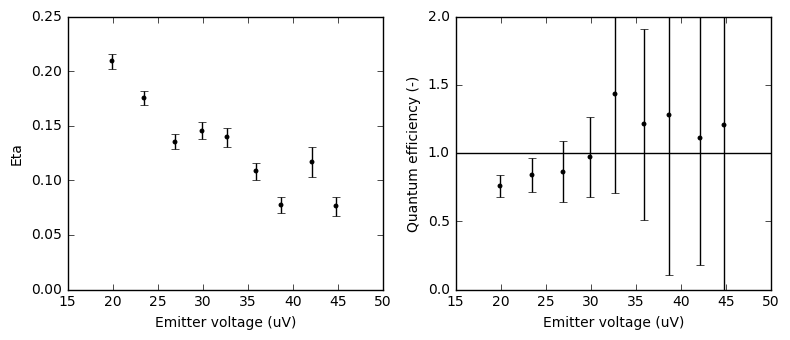

In [75]:
plt.figure(figsize=(8, 3.5))
plt.subplot(1, 2, 1)
plt.errorbar(V_emis / 1e-6, etas, yerr=etas_err, fmt='.', color='black')
plt.xlim(15, 50)
plt.ylim(0, 0.25)
plt.xlabel('Emitter voltage (uV)')
plt.ylabel('Eta')

plt.subplot(1, 2 ,2)
plt.errorbar(V_emis / 1e-6, effs, yerr=effs_err, fmt='.', color='black')
plt.xlabel('Emitter voltage (uV)')
plt.ylabel('Quantum efficiency (-)')
plt.axhline(1, color='black')
plt.xlim(15, 50)
plt.ylim(0, 2)

plt.tight_layout()